# Cohort Retention Anlysis, Customer Lifetime Value and K-means clustering using RFM

![My Image](https://re7consulting.ro/wp-content/uploads/2024/02/customer-lifetime-value-chart.png)

<a id="section-top"></a>
## Table of Contents

* [1. Import related libraries and load dataset](#section-one)

* [2. Data Wrangling](#section-two)

* [3. Exploratory Data Analysis (EDA)](#section-three)

* [4. Cohort Retention Analysis](#section-four)
     - [4.1. Retention Rate by Time Period](#section-four-one)
     - [4.2. Retention Rate by Time Period by Country](#section-four-two)

* [5. Customer Lifetime Value](#section-five)
     - [5.1. R-F-M calculation](#section-five-one)
     - [5.2. Beta Geometric/Negative Binomial Distribution (BG/NBD) model](#section-five-two)
     - [5.3. Gamma-Gamma model](#section-five-three)
     - [5.4. Customer Lifetime Value prediction](#section-five-four)

* [6. RFM segmentation with K-means](#section-six)


<a id="section-one"></a>
## 1. Import related libraries and load dataset

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from pymc_marketing import clv
import datetime as dt
import seaborn as sns

**Dataset:** https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci/code?datasetId=430934&sortBy=voteCount

**Attribute Information:**

**InvoiceNo:** *Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.*

**StockCode:** *Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.*

**Description:** *Product (item) name. Nominal.*

**Quantity:** *The quantities of each product (item) per transaction. Numeric.*

**InvoiceDate:** *Invice date and time. Numeric. The day and time when a transaction was generated.*

**UnitPrice:** *Unit price. Numeric. Product price per unit in sterling .*

**CustomerID:** Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.

**Country:** *Country name. Nominal. The name of the country where a customer resides.*

In [74]:
df = pd.read_csv("../dataset/archive/online_retail_II.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [76]:
df.describe(include= 'all')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
count,1067371,1067371,1062989,1.067371e+06,1067371,1.067371e+06,824364.000000,1067371
unique,53628,5305,5698,NaN,47635,NaN,NaN,43
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2010-12-06 16:57:00,NaN,NaN,United Kingdom
freq,1350,5829,5918,NaN,1350,NaN,NaN,981330
mean,NaN,NaN,NaN,9.938898e+00,NaN,4.649388e+00,15324.638504,NaN
std,NaN,NaN,NaN,1.727058e+02,NaN,1.235531e+02,1697.464450,NaN
min,NaN,NaN,NaN,-8.099500e+04,NaN,-5.359436e+04,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000e+00,NaN,1.250000e+00,13975.000000,NaN
50%,NaN,NaN,NaN,3.000000e+00,NaN,2.100000e+00,15255.000000,NaN
75%,NaN,NaN,NaN,1.000000e+01,NaN,4.150000e+00,16797.000000,NaN


<a id="section-two"></a>
## 2. Data Wrangling

*Invoice starts with the letter 'C', it indicates a cancellation*

In [77]:
#Check the Invoice column to show all row starts with the letter 'C'
df[df["Invoice"].str.contains("^C")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
1065910,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
1067002,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
1067176,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
1067177,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [78]:
#Remove all row starts with the letter 'C'
df = df[~df['Invoice'].str.contains('C', na=False)]

In [79]:
#Check null value
df.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    242257
Country             0
dtype: int64

In [80]:
# Drop null value
df.dropna(subset = ['Customer ID'], axis=0, inplace= True)

In [81]:
#Check unavaiable StockCode
df[(df["StockCode"].str.match("^\\d{5}$") == False) & (df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]["StockCode"].unique()

array(['POST', 'C2', 'M', 'BANK CHARGES', 'TEST001', 'TEST002', 'PADS',
       'ADJUST', 'D', 'ADJUST2', 'SP1002', 'DOT'], dtype=object)

In [82]:
#Only hold the StockCode containing a 5-digit integral numbers
df = df[(df["StockCode"].str.match("^\\d{5}$") == True) | (df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == True)]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [83]:
#Convert InvoiceDate data type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'].dt.strftime('%Y-%m-%d'))

#Create Revenue column
df['Revenue'] = df['Quantity']*df['Price']

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,30.0


<a id="section-three"></a>
## 3. Exploratory Data Analysis (EDA)

In [84]:
#Initial assessment
print('Total number of stockcodes:', df['StockCode'].nunique())
print('Total number of transactions:', df['Invoice'].nunique())
print('Total number of customers:', df['Customer ID'].nunique(), 'persons')
print('Total items was sold:',  df['Quantity'].sum(),'items')
print('Total revenue generated:', df['Customer ID'].sum(), 'dollars')
print('Item sold price between', df['Price'].min(),'and', df['Price'].max(), 'dollars')
print('Time range from', df['InvoiceDate'].min(),'to', df['InvoiceDate'].max())
print('Time range in day:', (df['InvoiceDate'].max() - df['InvoiceDate'].min()).days, 'days')

Total number of stockcodes: 4619
Total number of transactions: 36597
Total number of customers: 5853 persons
Total items was sold: 10705161 items
Total revenue generated: 12311768036.0 dollars
Item sold price between 0.0 and 649.5 dollars
Time range from 2009-12-01 00:00:00 to 2011-12-09 00:00:00
Time range in day: 738 days


<Axes: title={'center': '20 countries with the most spending'}, ylabel='Country'>

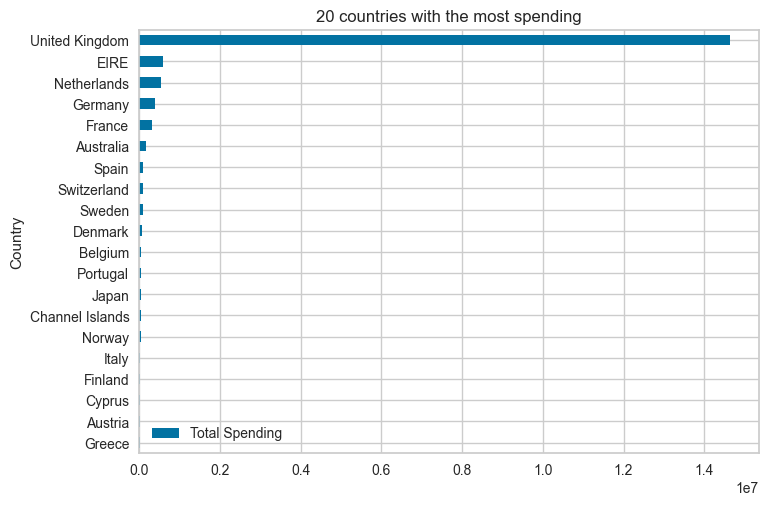

In [85]:
#Spending by country
country = df[['Country', 'Revenue']].groupby('Country', as_index= False)['Revenue'].sum().sort_values(by='Revenue', ascending=True)
country.rename(columns= {'Revenue':'Total Spending'}, inplace= True)

country.tail(20).plot(kind= 'barh', x= 'Country', y= 'Total Spending', title =  '20 countries with the most spending')

<Axes: title={'center': '20 stockcodes with the most quantity purchased'}, ylabel='StockCode'>

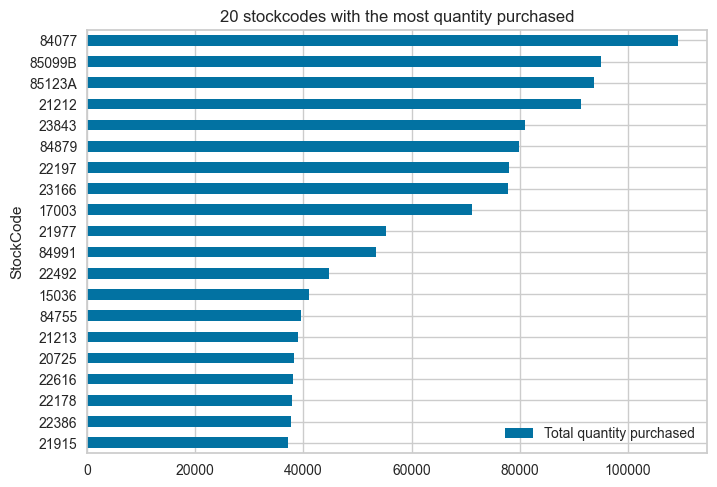

In [147]:
#Quantity purchased per product
stockcode = df[['StockCode', 'Quantity']].groupby('StockCode', as_index= False)['Quantity'].sum().sort_values(by='Quantity', ascending=True)
stockcode.rename(columns= {'Quantity':'Total quantity purchased'}, inplace= True)

stockcode.tail(20).plot(kind= 'barh', x= 'StockCode', y= 'Total quantity purchased', title =  '20 stockcodes with the most quantity purchased')

<Axes: title={'center': '20 persons with the most spending'}, ylabel='Customer ID'>

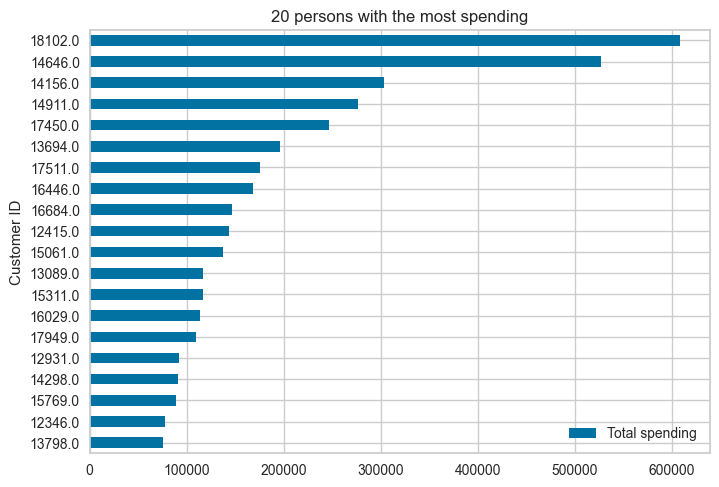

In [89]:
#Spending by customer
customer = df[['Customer ID', 'Revenue']].groupby('Customer ID', as_index= False)['Revenue'].sum().sort_values(by='Revenue', ascending=True)
customer.rename(columns= {'Revenue':'Total spending'}, inplace= True)

customer.tail(20).plot(kind= 'barh', x= 'Customer ID', y= 'Total spending', title =  '20 persons with the most spending')

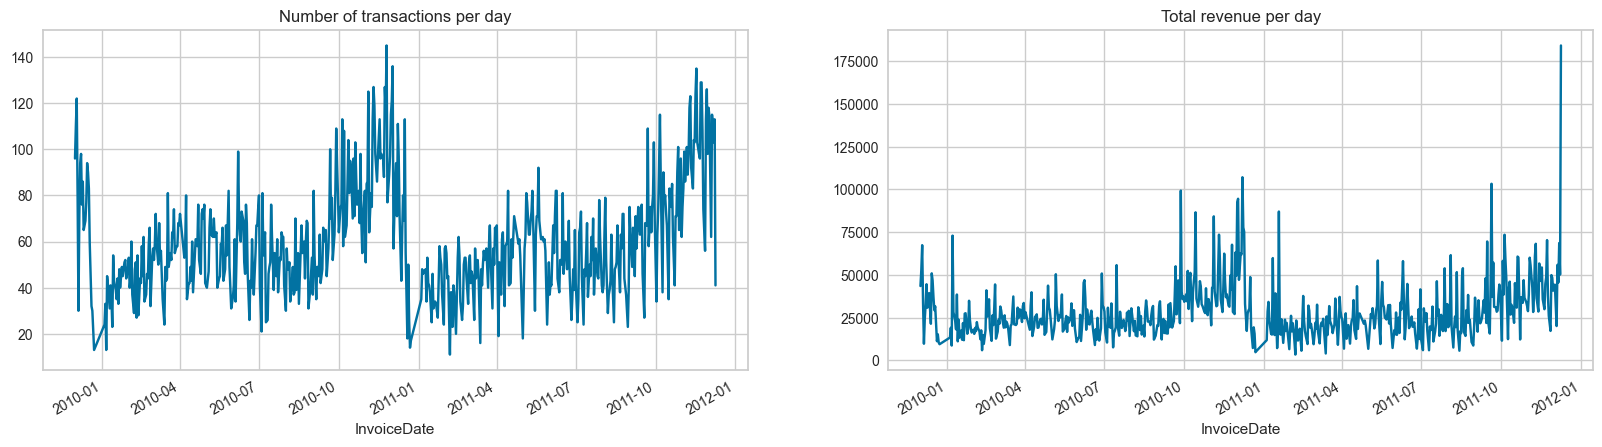

In [146]:
plt.figure(figsize=(20, 5))

#Number of transactions per day
plt.subplot(1,2,1)
transaction = df[['InvoiceDate', 'Invoice']].groupby('InvoiceDate')['Invoice'].nunique()
transaction.plot(kind= 'line', x='InvoiceDate', y= 'Invoice', title= 'Number of transactions per day')

#Total revenue per day
plt.subplot(1,2,2)
revenue = df[['InvoiceDate', 'Revenue']].groupby('InvoiceDate')['Revenue'].sum()
revenue.plot(kind= 'line', x='InvoiceDate', y= 'Revenue', title= 'Total revenue per day')

plt.show()

<a id="section-four"></a>
## 4. Cohort Retention Analysis

**Cohort analysis** *is a type of behavioral analytics in which you take a group of users, and analyze their usage patterns based on their shared traits to better track and understand their actions. A cohort is simply a group of people with shared characteristics.*

*Source: https://www.appcues.com/blog/cohort-analysis#:~:text=with%20cohort%20analysis.-,What%20is%20cohort%20analysis%3F,of%20people%20with%20shared%20characteristics.*

<a id="section-four-one"></a>
### 4.1. Retention Rate by Time Period

In [90]:
#Function to record by month
def get_month(x): return dt.datetime(x.year, x.month, 1)

#Extract the column to year, month, day
def get_date(df, col):
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    return year, month, day

In [91]:
#Create new df with related columns
cohort1_df = df[['Customer ID', 'InvoiceDate']].copy()

In [92]:
cohort1_df['Invoice_date'] = cohort1_df['InvoiceDate'].apply(get_month)

cohort1_df['Cohort_date'] = cohort1_df.groupby('Customer ID')['Invoice_date'].transform(min) #Return the column with the first month a customer makes a purchase but do not remove other related rows

Invoice_year, Invoice_month, Invoice_day = get_date(cohort1_df, 'Invoice_date')

Cohort_year, Cohort_month, Cohort_day = get_date(cohort1_df, 'Cohort_date')

Year_diff = Invoice_year - Cohort_year

Month_diff = Invoice_month - Cohort_month

cohort1_df['Cohort_index'] = 12*Year_diff + Month_diff #The assumption that the Cohort_index is equal to 0 the first month a customer made a purchase

cohort1_df.head()

,Customer ID,InvoiceDate,Invoice_date,Cohort_date,Cohort_index
0,13085.0,2009-12-01,2009-12-01,2009-12-01,0
1,13085.0,2009-12-01,2009-12-01,2009-12-01,0
2,13085.0,2009-12-01,2009-12-01,2009-12-01,0
3,13085.0,2009-12-01,2009-12-01,2009-12-01,0
4,13085.0,2009-12-01,2009-12-01,2009-12-01,0


In [93]:
#Count distinct number of customers by Cohort_date and Cohort_index
cohort1_final = cohort1_df[['Customer ID', 'Cohort_index', 'Cohort_date']].groupby(['Cohort_date', 'Cohort_index'], as_index = False)['Customer ID'].nunique()
cohort1_final.head()

,Cohort_date,Cohort_index,Customer ID
0,2009-12-01,0,951
1,2009-12-01,1,333
2,2009-12-01,2,317
3,2009-12-01,3,404
4,2009-12-01,4,360


In [94]:
#Pivot long to wide dataset
time_result = cohort1_final.pivot(index= 'Cohort_date',columns='Cohort_index', values='Customer ID')
time_result.index = time_result.index.date #Convert Cohort_index to date type

time_result.head()

Cohort_index,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
2009-12-01,951.0,333.0,317.0,404.0,360.0,342.0,358.0,327.0,321.0,344.0,...,288.0,250.0,288.0,270.0,246.0,242.0,298.0,289.0,386.0,187.0
2010-01-01,368.0,79.0,118.0,116.0,100.0,114.0,99.0,86.0,105.0,120.0,...,56.0,90.0,75.0,71.0,74.0,93.0,73.0,93.0,21.0,NaN
2010-02-01,375.0,88.0,85.0,110.0,92.0,74.0,72.0,108.0,96.0,104.0,...,75.0,60.0,61.0,54.0,86.0,86.0,62.0,22.0,NaN,NaN
2010-03-01,441.0,84.0,102.0,107.0,102.0,90.0,109.0,135.0,122.0,48.0,...,75.0,77.0,69.0,78.0,90.0,94.0,34.0,NaN,NaN,NaN
2010-04-01,294.0,56.0,56.0,47.0,54.0,65.0,81.0,78.0,31.0,32.0,...,46.0,41.0,44.0,53.0,67.0,17.0,NaN,NaN,NaN,NaN


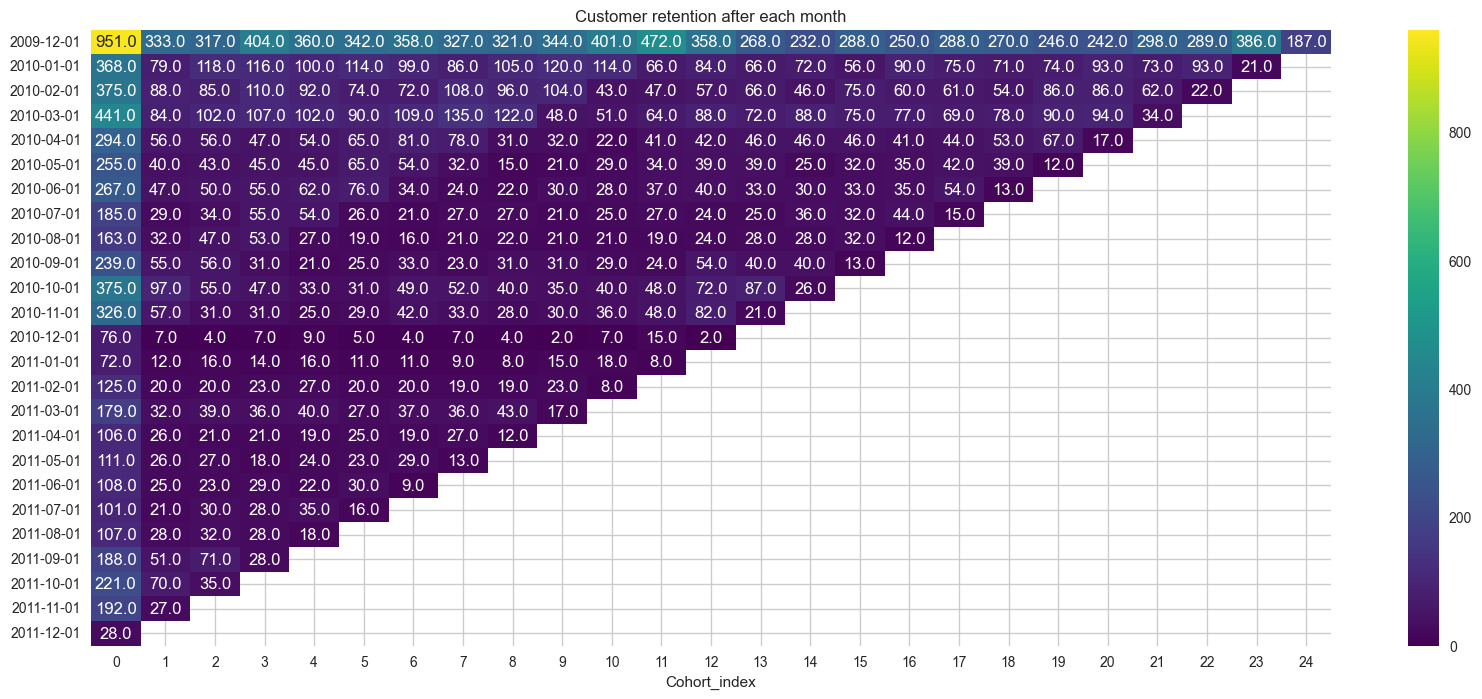

In [95]:
#Visual Retention by number of customers
plt.figure(figsize=(20, 8))
plt.title('Customer retention after each month')
sns.heatmap(data= time_result,annot = True,fmt= '0', vmin = 0,vmax = 960,cmap="viridis")

plt.show()

In [96]:
#Create new df to visual retention rate
retention_rate_result1 = round(time_result.divide(time_result.iloc[:, 0], axis = 0),4)

retention_rate_result1.head()

Cohort_index,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
2009-12-01,1.0,0.3502,0.3333,0.4248,0.3785,0.3596,0.3764,0.3438,0.3375,0.3617,...,0.3028,0.2629,0.3028,0.2839,0.2587,0.2545,0.3134,0.3039,0.4059,0.1966
2010-01-01,1.0,0.2147,0.3207,0.3152,0.2717,0.3098,0.2690,0.2337,0.2853,0.3261,...,0.1522,0.2446,0.2038,0.1929,0.2011,0.2527,0.1984,0.2527,0.0571,NaN
2010-02-01,1.0,0.2347,0.2267,0.2933,0.2453,0.1973,0.1920,0.2880,0.2560,0.2773,...,0.2000,0.1600,0.1627,0.1440,0.2293,0.2293,0.1653,0.0587,NaN,NaN
2010-03-01,1.0,0.1905,0.2313,0.2426,0.2313,0.2041,0.2472,0.3061,0.2766,0.1088,...,0.1701,0.1746,0.1565,0.1769,0.2041,0.2132,0.0771,NaN,NaN,NaN
2010-04-01,1.0,0.1905,0.1905,0.1599,0.1837,0.2211,0.2755,0.2653,0.1054,0.1088,...,0.1565,0.1395,0.1497,0.1803,0.2279,0.0578,NaN,NaN,NaN,NaN


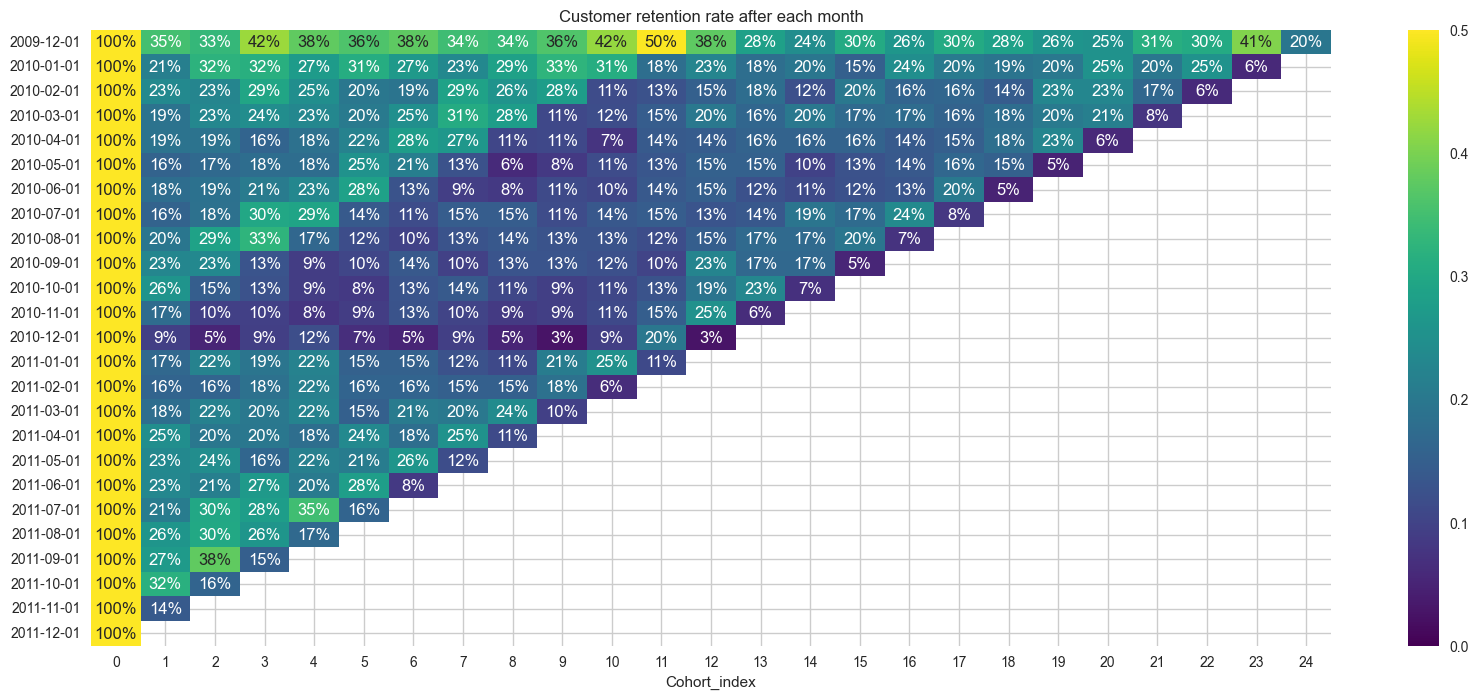

In [97]:
#Visual retention rate
plt.figure(figsize=(20, 8))
plt.title('Customer retention rate after each month')
sns.heatmap(data=retention_rate_result1,annot = True,fmt= '.0%', vmin = 0,vmax = 0.5,cmap="viridis")

plt.show()

In [98]:
#Total customer retention after each month
ret_rate = cohort1_final[['Customer ID', 'Cohort_index']].groupby('Cohort_index', as_index = False)['Customer ID'].sum()

#Total customer retention rate after each month
ret_rate['Retention_rate'] = ((ret_rate['Customer ID']/ret_rate['Customer ID'].max())*100).round(2)

ret_rate

,Cohort_index,Customer ID,Retention_rate
0,0,5853,100.00
1,1,1342,22.93
2,2,1312,22.42
3,3,1333,22.77
4,4,1185,20.25
5,5,1113,19.02
6,6,1097,18.74
7,7,1057,18.06
8,8,946,16.16
9,9,894,15.27


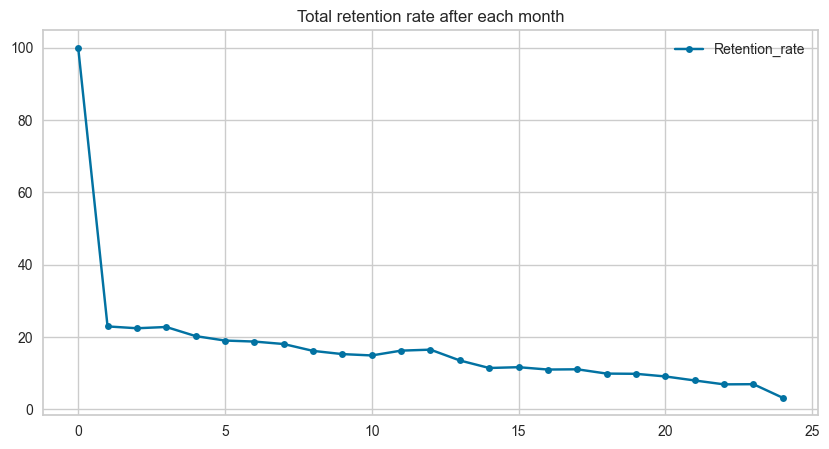

In [148]:
#Visual total customer retention rate 
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(ret_rate['Cohort_index'], 
        ret_rate['Retention_rate'],
        marker ="o",
        markersize= 5)
plt.grid(True)
plt.title('Total retention rate after each month')
plt.legend(['Retention_rate'])

plt.show()

<a id="section-four-two"></a>
### 4.2. Retention Rate by Time Period by Country

In [193]:
#Create a new df to include Customer ID and their Country 
customer_country_df = df[['Customer ID', 'Country']].drop_duplicates(subset=['Customer ID']).reset_index(drop = True)
display(customer_country_df.head())
display(customer_country_df.shape)

,Customer ID,Country
0,13085.0,United Kingdom
1,13078.0,United Kingdom
2,15362.0,United Kingdom
3,18102.0,United Kingdom
4,12682.0,France


(5853, 2)

In [181]:
#Merge with cohort1_df 
cohort2_df =pd.merge(cohort1_df, customer_country_df, on= 'Customer ID', how= 'left')
cohort2_df.head()

,Customer ID,InvoiceDate,Invoice_date,Cohort_date,Cohort_index,Country
0,13085.0,2009-12-01,2009-12-01,2009-12-01,0,United Kingdom
1,13085.0,2009-12-01,2009-12-01,2009-12-01,0,United Kingdom
2,13085.0,2009-12-01,2009-12-01,2009-12-01,0,United Kingdom
3,13085.0,2009-12-01,2009-12-01,2009-12-01,0,United Kingdom
4,13085.0,2009-12-01,2009-12-01,2009-12-01,0,United Kingdom


In [182]:
#Count distinct number of customers by Country and Cohort_index
cohort2_final = cohort2_df[['Customer ID', 'Cohort_index', 'Country']].groupby(['Cohort_index', 'Country'], as_index = False)['Customer ID'].nunique()
cohort2_final.head()

,Cohort_index,Country,Customer ID
0,0,Australia,14
1,0,Austria,12
2,0,Bahrain,2
3,0,Belgium,27
4,0,Brazil,2


In [184]:
#Pivot long to wide
time_country_result = cohort2_final.pivot(index= 'Country',columns='Cohort_index', values='Customer ID')

time_country_result.head()

Cohort_index,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Country,,,,,,,,,,,,,,,,,,,,,
Australia,14.0,3.0,1.0,3.0,5.0,2.0,1.0,2.0,2.0,4.0,...,1.0,2.0,1.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN
Austria,12.0,3.0,NaN,2.0,NaN,2.0,3.0,2.0,1.0,2.0,...,2.0,NaN,NaN,1.0,2.0,2.0,NaN,NaN,NaN,1.0
Bahrain,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Belgium,27.0,6.0,6.0,3.0,12.0,7.0,8.0,6.0,7.0,5.0,...,3.0,5.0,1.0,4.0,3.0,2.0,2.0,2.0,NaN,1.0
Brazil,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


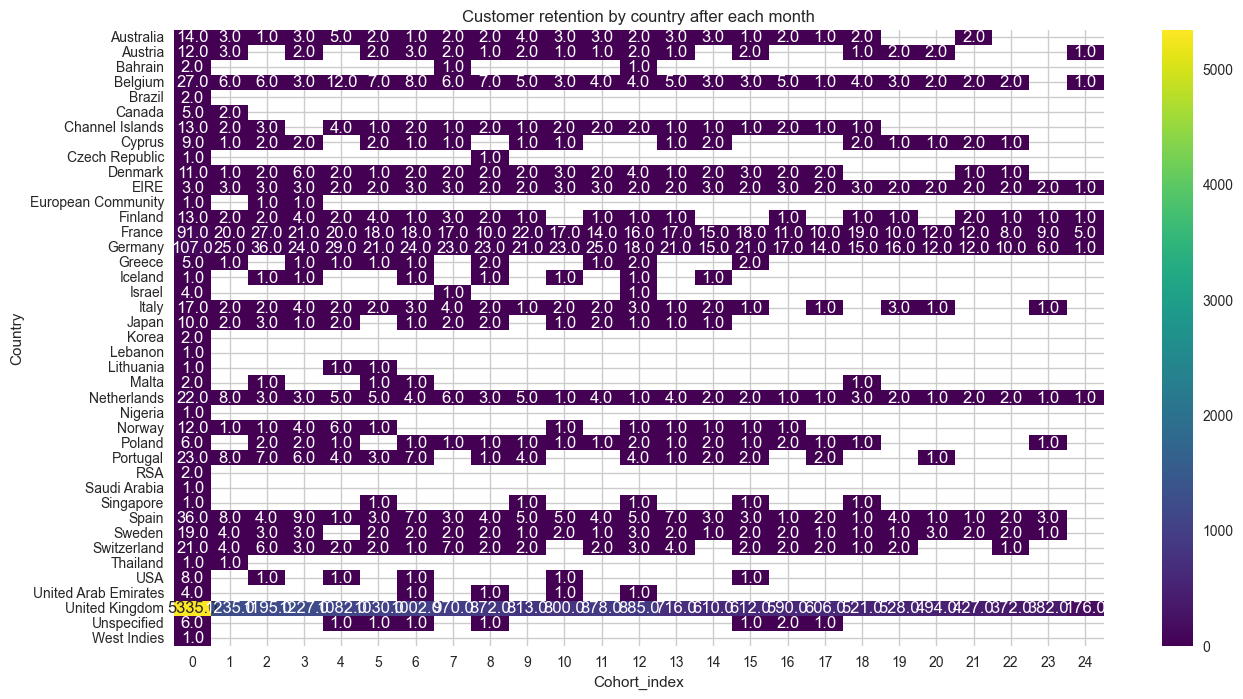

In [185]:
#Visual Retention by number of customers by country
plt.figure(figsize=(15, 8))
plt.title('Customer retention by country after each month')
sns.heatmap(data= time_country_result,annot = True,fmt= '0', vmin = 0,vmax = 5335,cmap="viridis")

plt.show()

In [189]:
#Create new df to visual retention rate by country
retention_rate_result2 = round(time_country_result.divide(time_country_result.iloc[:, 0], axis = 0),4)

retention_rate_result2.head()

Cohort_index,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Country,,,,,,,,,,,,,,,,,,,,,
Australia,1.0,0.2143,0.0714,0.2143,0.3571,0.1429,0.0714,0.1429,0.1429,0.2857,...,0.0714,0.1429,0.0714,0.1429,NaN,NaN,0.1429,NaN,NaN,NaN
Austria,1.0,0.2500,NaN,0.1667,NaN,0.1667,0.2500,0.1667,0.0833,0.1667,...,0.1667,NaN,NaN,0.0833,0.1667,0.1667,NaN,NaN,NaN,0.0833
Bahrain,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Belgium,1.0,0.2222,0.2222,0.1111,0.4444,0.2593,0.2963,0.2222,0.2593,0.1852,...,0.1111,0.1852,0.0370,0.1481,0.1111,0.0741,0.0741,0.0741,NaN,0.0370
Brazil,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


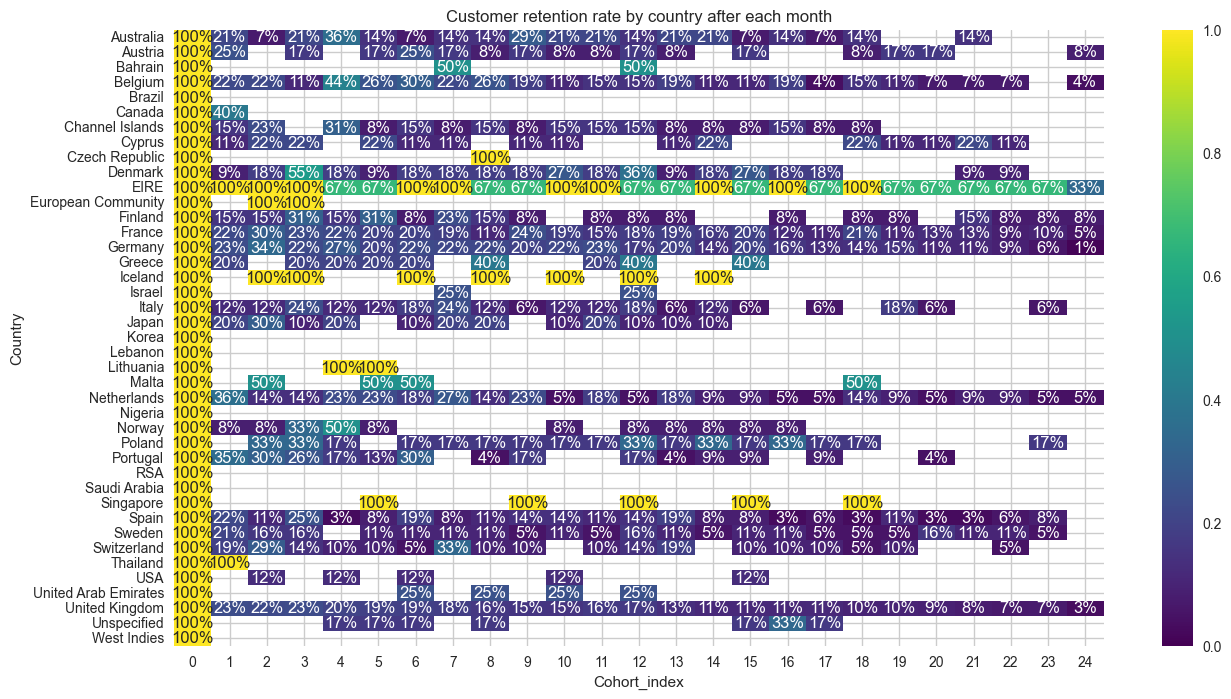

In [190]:
#Visual Retention rate by number of customers by country
plt.figure(figsize=(15, 8))
plt.title('Customer retention rate by country after each month')
sns.heatmap(data=retention_rate_result2,annot = True,fmt= '.0%', vmin = 0,vmax = 1,cmap="viridis")

plt.show()

<a id="section-five"></a>
## 5. Customer Lifetime Value

*The usual workflow of using the lifetimes library:*
![My Image](https://i.imgur.com/oV2KpQG.png)
*Source: https://lifetimes.readthedocs.io/en/latest/High%20Level%20Overview.html*

<a id="section-five-one"></a>
### 5.1. R-F-M calculation

In [107]:
#Create new df with related columns
df_rfm = df[['Customer ID', 'Invoice', 'InvoiceDate', 'Revenue']].copy()
df_rfm.head()

,Customer ID,Invoice,InvoiceDate,Revenue
0,13085.0,489434,2009-12-01,83.4
1,13085.0,489434,2009-12-01,81.0
2,13085.0,489434,2009-12-01,81.0
3,13085.0,489434,2009-12-01,100.8
4,13085.0,489434,2009-12-01,30.0


In [108]:
#Function to define duration between a customer’s first purchase and the end of the period under study
def time_diff_to_year_end(transaction_dates):
    first_transaction = transaction_dates.min()
    last_trasaction_year = transaction_dates.max().year
    last_day_of_last_year = pd.Timestamp(year=last_trasaction_year, month=12, day=31) 
    return (last_day_of_last_year - first_transaction).days

#Function to define duration between a customer’s first purchase and their latest purchase
def time_diff_to_last_transaction(transaction_dates):
    first_transaction = transaction_dates.min()
    last_trasaction = transaction_dates.max()
    return (last_trasaction - first_transaction).days


***The shape of data:***

**Frequency** *represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.*

**T** *represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.*

**Recency** *represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)*

**Monetary** *represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.*

*Source:https://lifetimes.readthedocs.io/en/latest/Quickstart.html#the-shape-of-your-data*

In [109]:
#Following the description above, we proceed to calculate the R-F-M features
rfm = df_rfm[['Customer ID', 'Invoice', 'Revenue', 'InvoiceDate']].groupby(['Customer ID'], as_index= False).agg(Monetary= pd.NamedAgg('Revenue', 'sum'),
                                                                                                                 Frequency= pd.NamedAgg('InvoiceDate', 'nunique'),
                                                                                                                 T= pd.NamedAgg('InvoiceDate', time_diff_to_year_end),
                                                                                                                 Recency = pd.NamedAgg('InvoiceDate', time_diff_to_last_transaction)
                                                                                                                 ) 

rfm['Monetary'] = (rfm['Monetary']/rfm['Frequency']).round()
rfm['Frequency'] = rfm['Frequency'] - 1
rfm['T'] = (rfm['T']/7).round() #Transfer to weekly
rfm['Recency'] = (rfm['Recency']/7).round()  #Transfer to weekly

rfm.head()

,Customer ID,Monetary,Frequency,T,Recency
0,12346.0,25784.0,2,96.0,46.0
1,12347.0,704.0,7,61.0,57.0
2,12348.0,332.0,4,66.0,52.0
3,12349.0,1226.0,2,87.0,82.0
4,12350.0,294.0,0,47.0,0.0


In [110]:
rfm.describe()

,Customer ID,Monetary,Frequency,T,Recency
count,5853.000000,5853.000000,5853.000000,5853.000000,5853.000000
mean,15319.354519,426.227234,4.617632,55.367846,39.107637
std,1714.995565,1395.091489,9.915813,34.995598,36.952081
min,12346.000000,0.000000,0.000000,1.000000,0.000000
25%,13837.000000,188.000000,0.000000,24.000000,0.000000
50%,15320.000000,300.000000,2.000000,49.000000,32.000000
75%,16802.000000,440.000000,5.000000,91.000000,73.000000
max,18287.000000,84236.000000,246.000000,109.000000,105.000000


In [111]:
#Make it able to analysis
rfm.replace({'Monetary': np.inf}, 0, inplace= True)
rfm = rfm[(rfm['Frequency'] > 1)]
rfm = rfm[(rfm['Recency'] > 0)].reset_index(drop= True)

In [112]:
rfm.shape

(3169, 5)

<a id="section-five-two"></a>
### 5.2. Beta Geometric/Negative Binomial Distribution (BG/NBD) model

In [113]:
#Create new df for analysis
cltv = rfm.copy()

In [114]:
#Implenisment BG/NBD model
from lifetimes import BetaGeoFitter 

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv['Frequency'], 
        cltv['Recency'], 
        cltv['T'])
print(bgf.summary)

            coef  se(coef)  lower 95% bound  upper 95% bound
r       1.896186  0.054276         1.789806         2.002566
alpha  17.717187  0.580090        16.580212        18.854163
a       0.002266  0.001734        -0.001132         0.005664
b       1.005236  0.336775         0.345157         1.665315


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

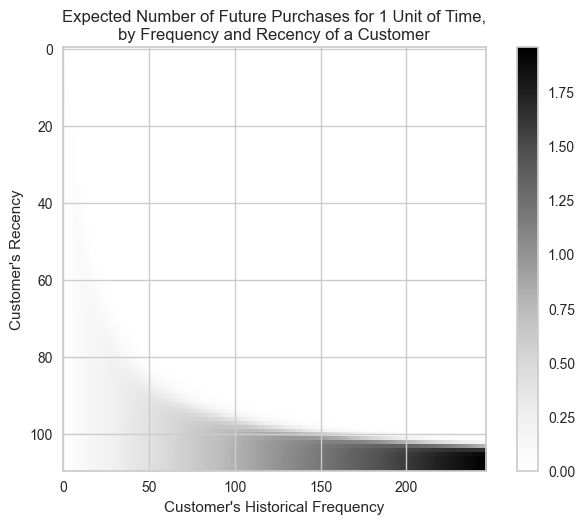

In [115]:
#Plot expected number of furture purchases
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

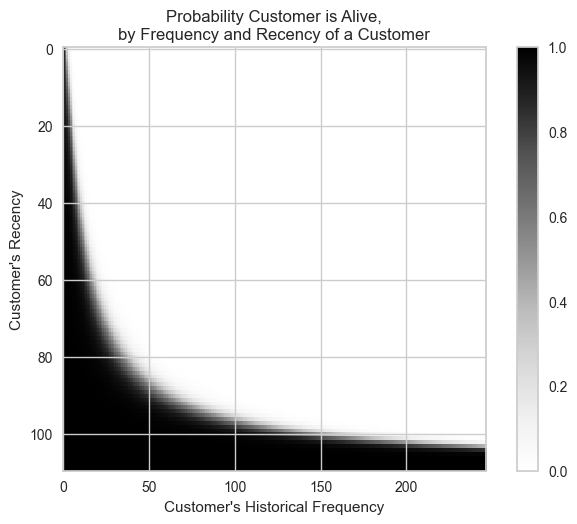

In [116]:
#Plot probability customer is alive
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

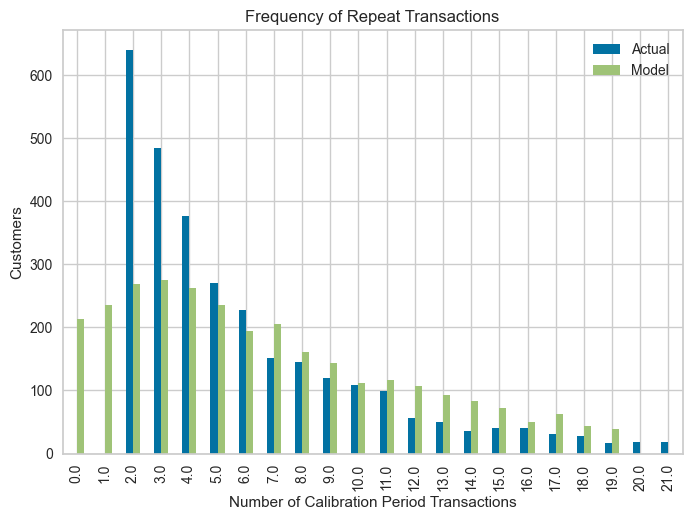

In [117]:
#Assessing model fit
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf, max_frequency= 20)

In [118]:
#Estimating alive probability of customer
cltv['p_alive'] = bgf.conditional_probability_alive(cltv['Frequency'],
                                                    cltv['Recency'],
                                                    cltv['T'])

cltv.head()

,Customer ID,Monetary,Frequency,T,Recency,p_alive
0,12346.0,25784.0,2,96.0,46.0,0.989319
1,12347.0,704.0,7,61.0,57.0,0.999486
2,12348.0,332.0,4,66.0,52.0,0.998338
3,12349.0,1226.0,2,87.0,82.0,0.998634
4,12352.0,192.0,8,59.0,51.0,0.999159


<a id="section-five-three"></a>
### 5.3. Gamma-Gamma model

*The Gamma-Gamma assumes that there is no relationship between the monetary value and the purchase frequency*

In [119]:
#Check correlation between two variables
cltv[['Frequency', 'Monetary']].corr()

,Frequency,Monetary
Frequency,1.00000,0.12932
Monetary,0.12932,1.00000


*-> The result shows the correlation is closest to zero meaning that there is no relationship between the monetary value and the purchase frequency*

In [120]:
#Implenisment Gamma-Gamma model
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(cltv['Frequency'],
        cltv['Monetary'])

print(ggf.summary)

         coef   se(coef)  lower 95% bound  upper 95% bound
p    2.344156   0.193174         1.965534         2.722777
q    3.655107   0.128457         3.403331         3.906882
v  478.818721  53.869475       373.234550       584.402892


<a id="section-five-four"></a>
### 5.4. Customer Lifetime Value prediction

*CLTV, this metric shows the total revenue your business could expect from a single customer throughout their lifetime*

In [121]:
#Expect number of purchases in the next 6 months (~26 weeks)
cltv['number_of_purchases_next_6_months'] = bgf.predict(26,
                                                       cltv['Frequency'],
                                                       cltv['Recency'], 
                                                       cltv['T']
                                                       ).round(2)
cltv.head()

,Customer ID,Monetary,Frequency,T,Recency,p_alive,number_of_purchases_next_6_months
0,12346.0,25784.0,2,96.0,46.0,0.989319,0.88
1,12347.0,704.0,7,61.0,57.0,0.999486,2.94
2,12348.0,332.0,4,66.0,52.0,0.998338,1.83
3,12349.0,1226.0,2,87.0,82.0,0.998634,0.97
4,12352.0,192.0,8,59.0,51.0,0.999159,3.35


In [122]:
print('Maximum number of purchases for the next 6 months',cltv['number_of_purchases_next_6_months'].max())
print('Minimum number of purchases for the next 6 months',cltv['number_of_purchases_next_6_months'].min())

Maximum number of purchases for the next 6 months 49.56
Minimum number of purchases for the next 6 months 0.0


In [123]:
#Expect the average transaction value
cltv['expect_average_profit'] = ggf.conditional_expected_average_profit(cltv['Frequency'],
                                                                        cltv['Monetary']
                                                                        ).round(2)

cltv.head()

,Customer ID,Monetary,Frequency,T,Recency,p_alive,number_of_purchases_next_6_months,expect_average_profit
0,12346.0,25784.0,2,96.0,46.0,0.989319,0.88,16614.31
1,12347.0,704.0,7,61.0,57.0,0.999486,2.94,664.83
2,12348.0,332.0,4,66.0,52.0,0.998338,1.83,352.02
3,12349.0,1226.0,2,87.0,82.0,0.998634,0.97,935.57
4,12352.0,192.0,8,59.0,51.0,0.999159,3.35,220.62


In [124]:
#Predicting total CLTV using the DCF method
cltv['cltv'] = ggf.customer_lifetime_value(bgf, #the model to use to predict the number of future transactions
                                           cltv['Frequency'],
                                           cltv['Recency'],
                                           cltv['T'],
                                           cltv['Monetary'],
                                           time=6, # months
                                           freq="W", # The frequency information of t.
                                           discount_rate=0.03 # monthly discount rate ~ 12.7% annually
                                           ).reset_index(drop= True)
cltv.head()

,Customer ID,Monetary,Frequency,T,Recency,p_alive,number_of_purchases_next_6_months,expect_average_profit,cltv
0,12346.0,25784.0,2,96.0,46.0,0.989319,0.88,16614.31,13250.587024
1,12347.0,704.0,7,61.0,57.0,0.999486,2.94,664.83,1766.894785
2,12348.0,332.0,4,66.0,52.0,0.998338,1.83,352.02,582.357237
3,12349.0,1226.0,2,87.0,82.0,0.998634,0.97,935.57,817.891486
4,12352.0,192.0,8,59.0,51.0,0.999159,3.35,220.62,669.018818


<a id="section-six"></a>
## 6. RFM segmentation with K-means

Text(0.5, 0, 'Recency')

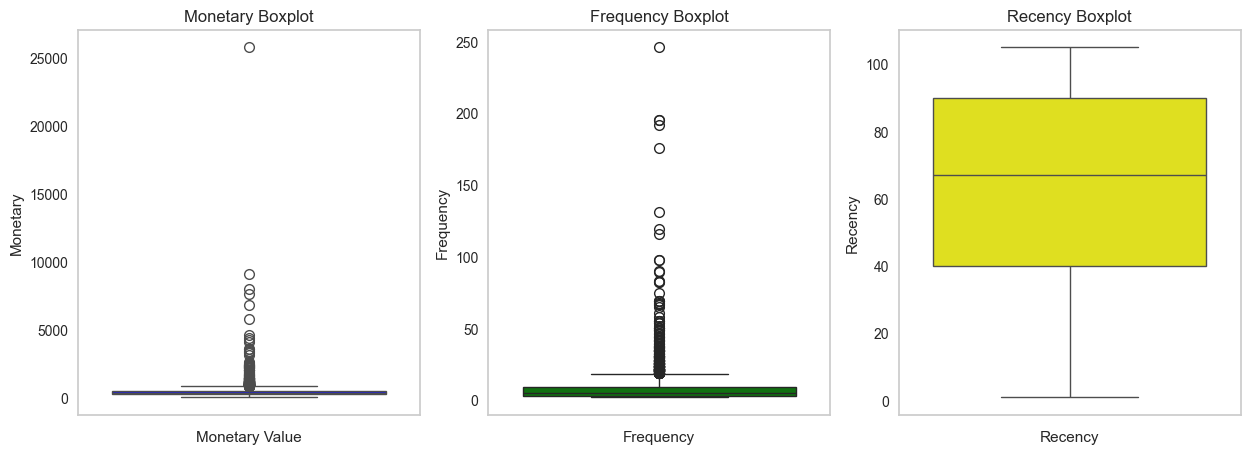

In [125]:
#Plotting the distribution of each feature with boxplot
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
sns.boxplot(data=rfm['Monetary'], color='blue')
plt.grid(False)
plt.title('Monetary Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1,3,2)
sns.boxplot(data=rfm['Frequency'], color='green')
plt.grid(False)
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1,3,3)
sns.boxplot(data=rfm['Recency'], color='yellow')
plt.grid(False)
plt.title('Recency Boxplot')
plt.xlabel('Recency')

In [126]:
#Function to define outlier
def outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    O1 = Q1 - 1.5*IQR
    O2 = Q3 + 1.5*IQR
    return O1, O2

In [127]:
#Remove monetary's outliers
M1, M2 = outliers(rfm['Monetary'])
monetary_outliers = rfm[(rfm['Monetary'] > M2) | (rfm['Monetary'] < M1)]
non_outliers_rfm_df = pd.merge(rfm, monetary_outliers, how='outer', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

In [128]:
#Remove frequency's outliers
F1, F2 = outliers(rfm['Frequency'])
frequency_outliers = rfm[(rfm['Frequency'] > F2) | (rfm['Frequency'] < F1)]
non_outliers_rfm_df = pd.merge(non_outliers_rfm_df, frequency_outliers, how='outer', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

In [129]:
non_outliers_rfm_df.head()

,Customer ID,Monetary,Frequency,T,Recency
0,12347.0,704.0,7,61.0,57.0
1,12348.0,332.0,4,66.0,52.0
2,12352.0,192.0,8,59.0,51.0
3,12358.0,689.0,4,108.0,104.0
4,12360.0,602.0,5,97.0,86.0


In [130]:
non_outliers_rfm_df.shape

(2711, 5)

In [131]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_df = scaler.fit_transform(non_outliers_rfm_df[["Monetary", "Frequency", "Recency"]])

scaled_df

array([[ 2.30001635e+00,  3.58383536e-01, -1.31735492e-01],
       [ 1.87999755e-03, -4.24305319e-01, -3.04347827e-01],
       [-8.63010027e-01,  6.19279821e-01, -3.38870293e-01],
       ...,
       [-2.26698080e-01, -6.85201604e-01,  4.08768420e-02],
       [-1.15954375e+00,  3.22824267e+00,  1.14559578e+00],
       [ 2.20734956e+00, -1.63409034e-01,  5.24191378e-01]])

In [132]:
scaled_df = pd.DataFrame(scaled_df, index=non_outliers_rfm_df.index, columns=("Monetary", "Frequency", "Recency"))

scaled_df.head()

,Monetary,Frequency,Recency
0,2.300016,0.358384,-0.131735
1,0.001880,-0.424305,-0.304348
2,-0.863010,0.619280,-0.338870
3,2.207350,-0.424305,1.490820
4,1.669882,-0.163409,0.869416


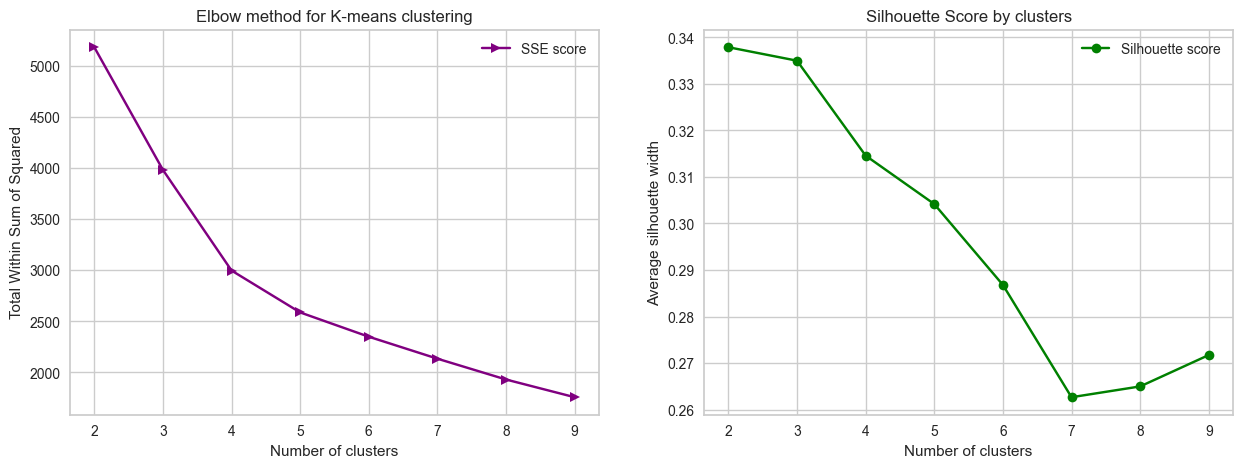

In [133]:
#Number of clusters(k) selection: Elbow and Sillhouette methods
data = scaled_df
sse = {}
score = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    score[k] = silhouette_score(data, kmeans.labels_) 

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(list(sse.keys()), list(sse.values()),
         marker= '>',
         c= 'purple')
plt.legend(['SSE score'])
plt.grid(True)
plt.title('Elbow method for K-means clustering')
plt.xlabel("Number of clusters")
plt.ylabel("Total Within Sum of Squared")

plt.subplot(1,2,2)
plt.plot(list(score.keys()), list(score.values()),
         marker="o",
         c= 'green')
plt.legend(['Silhouette score'])
plt.grid(True)
plt.title('Silhouette Score by clusters')
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette width")

plt.show()

In [134]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)
kmeans.fit(scaled_df)
labels = kmeans.labels_
print(labels)

[2 3 0 ... 0 1 2]


In [135]:
kmeans.inertia_

2997.509490650627

In [136]:
#Assessing the metric Between Clusters Sum of Squared(BSS)/Total Cluster Sum of Squared(TSS)
TSS = np.sum((scaled_df-scaled_df.mean(0))**2)   
BSS = TSS.sum() - kmeans.inertia_
Clustering_efficiency = ((BSS/TSS.sum())*100).round(2) #TSS = BSS + SSE(Total Within Cluster Sum of Squared)
print('The percentage of the data variance that is explained by the clustering:', Clustering_efficiency, '%')

The percentage of the data variance that is explained by the clustering: 63.14 %


In [137]:
non_outliers_rfm_df["Cluster"] = labels
non_outliers_rfm_df.head(5)

,Customer ID,Monetary,Frequency,T,Recency,Cluster
0,12347.0,704.0,7,61.0,57.0,2
1,12348.0,332.0,4,66.0,52.0,3
2,12352.0,192.0,8,59.0,51.0,0
3,12358.0,689.0,4,108.0,104.0,2
4,12360.0,602.0,5,97.0,86.0,2


In [138]:
#Number of customers per each cluster
cus_per_clus = non_outliers_rfm_df[['Customer ID', 'Cluster']].groupby('Cluster', as_index= False).nunique()
print('Number of customers per cluster: \n', cus_per_clus)

Number of customers per cluster: 
    Cluster  Customer ID
0        0          811
1        1          507
2        2          495
3        3          898


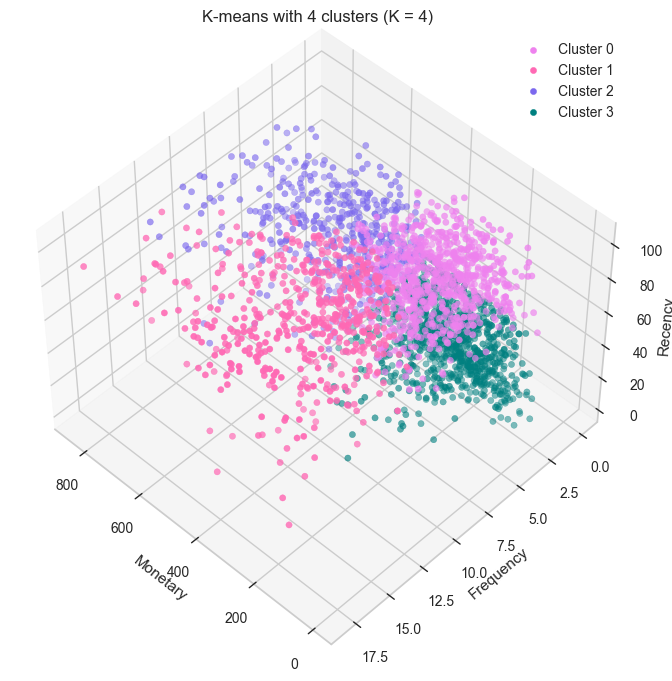

In [139]:
#Visual 3D cluster
cluster_colors = {0: 'violet',
                  1: 'hotpink', 
                  2: 'mediumslateblue', 
                  3: 'teal'} 

colors = non_outliers_rfm_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d', elev=48, azim=134)

ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

scatter_handles = []
for cluster, color in cluster_colors.items():
    scatter_handles.append(ax.scatter([], [], [], c=color, label=f'Cluster {cluster}'))
ax.legend(loc="best")

ax.scatter(non_outliers_rfm_df['Monetary'], 
           non_outliers_rfm_df['Frequency'], 
           non_outliers_rfm_df['Recency'],
           c= colors)
plt.title('K-means with 4 clusters (K = 4)')

plt.show()

c:\Users\Zenbook\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


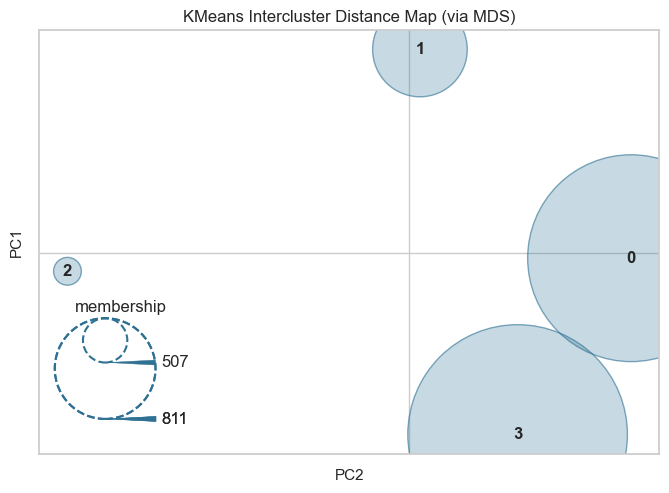

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [140]:
from yellowbrick.cluster import InterclusterDistance

# Instantiate the clustering model and visualizer
visualizer = InterclusterDistance(kmeans)
visualizer.fit(scaled_df) # Fit the data to the visualizer

visualizer.show() 

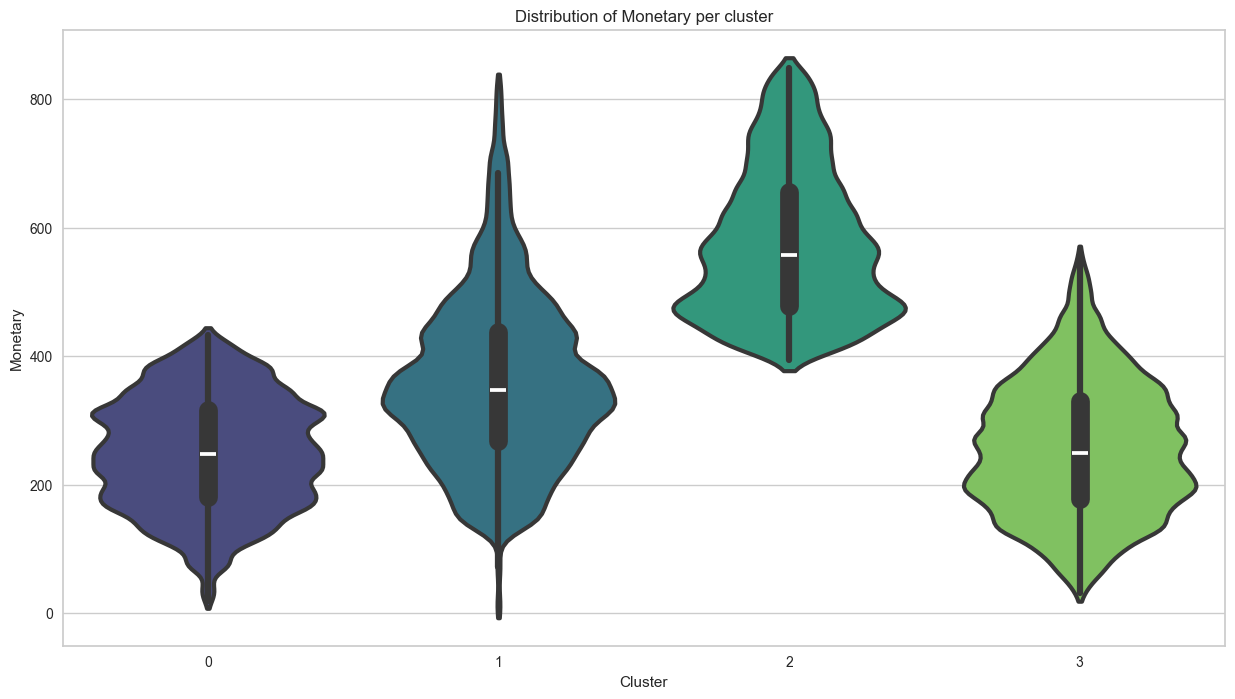

In [141]:
#Plotting distribution of Monetary per cluster
plt.figure(figsize=(15, 8))
sns.violinplot(data=non_outliers_rfm_df, x="Cluster", y="Monetary", bw_adjust=.5, cut=1, linewidth=3, palette="viridis")
plt.title('Distribution of Monetary per cluster')

plt.show()

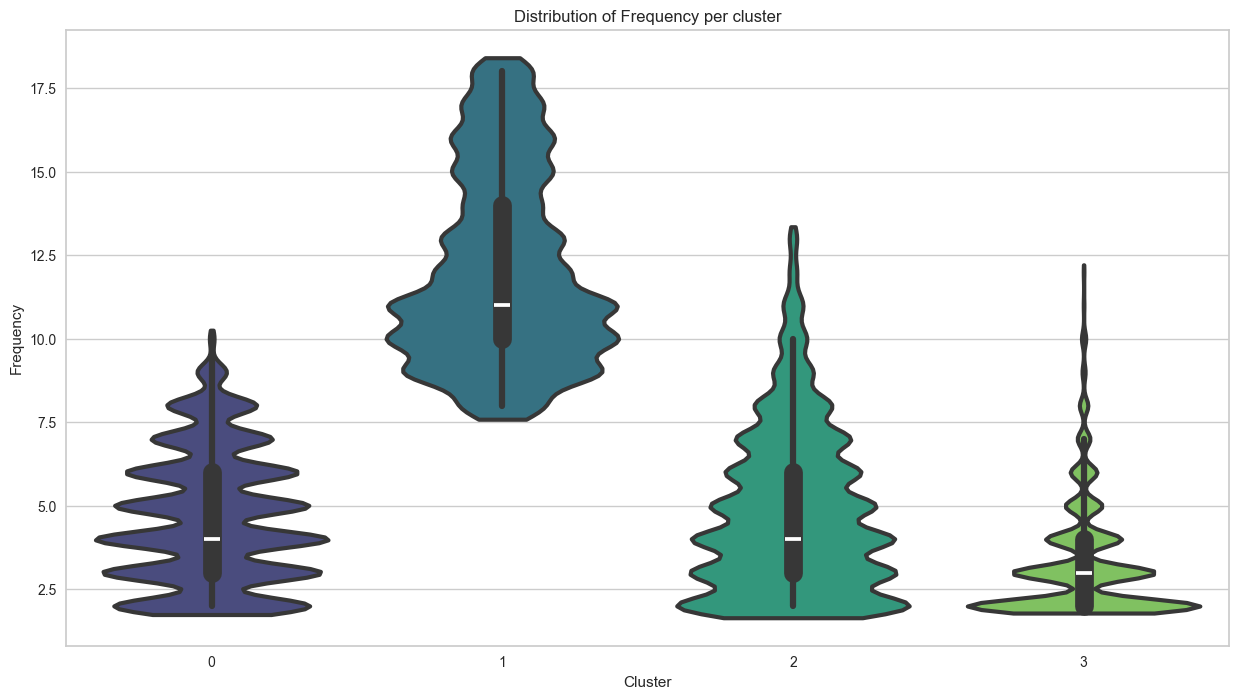

In [142]:
#Plotting distribution of Frequency per cluster
plt.figure(figsize=(15, 8))
sns.violinplot(data=non_outliers_rfm_df, x="Cluster", y="Frequency", bw_adjust=.5, cut=1, linewidth=3, palette="viridis")
plt.title('Distribution of Frequency per cluster')

plt.show()

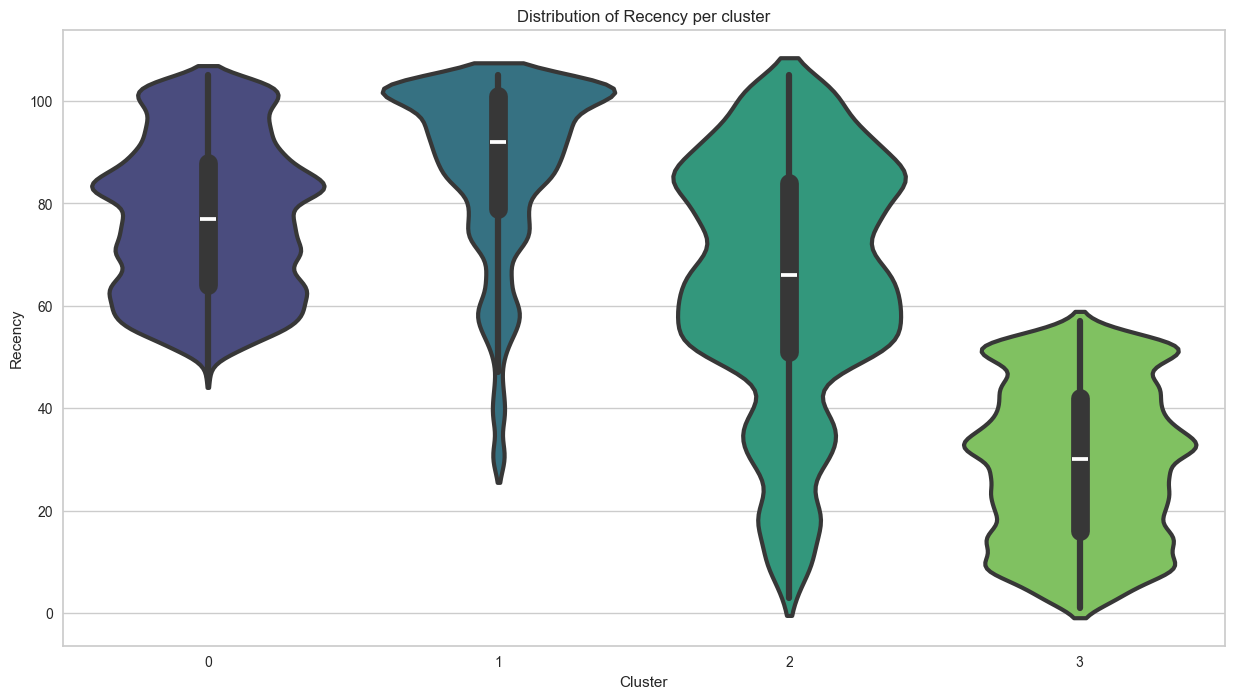

In [143]:
#Plotting distribution of Recency per cluster
plt.figure(figsize=(15, 8))
sns.violinplot(data=non_outliers_rfm_df, x="Cluster", y="Recency", bw_adjust=.5, cut=1, linewidth=3, palette="viridis")
plt.title('Distribution of Recency per cluster')

plt.show()